In [28]:
# Libraries
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *
from pyomo.opt import SolverFactory
import gym
import numpy as np
import torch
from stable_baselines3 import PPO, A2C, SAC, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv

In [2]:
# Loading datasets
purchase_prices = pd.read_csv('data/2017PurchasePricesDec.csv')
beg_inv = pd.read_csv('data/BegInvFINAL12312016.csv')
invoice_purchases = pd.read_csv('data/InvoicePurchases12312016.csv')
sales = pd.read_csv('data/SalesFINAL12312016.csv')

purchases = pd.read_csv('data/PurchasesFINAL12312016.csv')
end_inv = pd.read_csv('data/EndInvFINAL12312016.csv')

In [ ]:
print("purchase_prices Columns:")
print(purchase_prices.columns.tolist())

print("\ninvoice_purchases Columns:")
print(invoice_purchases.columns.tolist())

print("\nsales Columns:")
print(sales.columns.tolist())

print("\nbeg_inv Columns:")
print(beg_inv.columns.tolist())

print("\nend_inv Columns:")
print(end_inv.columns.tolist())

print("\npurchases Columns:")
print(purchases.columns.tolist())


In [ ]:
# Checking for missing data in each dataset
datasets = [purchase_prices, beg_inv, end_inv, invoice_purchases, purchases, sales]
dataset_names = ["purchase_prices", "beg_inv", "end_inv", "invoice_purchases", "purchases", "sales"]

for name, data in zip(dataset_names, datasets):
    missing_values = data.isnull().sum()
    non_zero_missing_values = missing_values[missing_values > 0]
    
    if not non_zero_missing_values.empty:
        print(f"\nMissing values in {name}:")
        print(non_zero_missing_values)
        
# Handling missing values for purchase_prices dataset
cols_to_check = ['Description', 'Size', 'Volume']
for col in cols_to_check:
    purchase_prices = purchase_prices[purchase_prices[col].notna()]

# Handling missing values for end_inv dataset
if end_inv['Store'].nunique() == end_inv['City'].nunique():
    city_store_mapping = end_inv[['Store', 'City']].drop_duplicates().set_index('Store').to_dict()['City']
    end_inv['City'] = end_inv['City'].fillna(end_inv['Store'].map(city_store_mapping))
else:
    end_inv['City'].fillna('Unknown', inplace=True)

# Handling missing values for invoice_purchases dataset
invoice_purchases['Approval'].fillna('Pending', inplace=True)

# Handling missing values for purchases dataset
purchases = purchases[purchases['Size'].notna()]

datasets = [purchase_prices, beg_inv, end_inv, invoice_purchases, purchases, sales]
dataset_names = ["purchase_prices", "beg_inv", "end_inv", "invoice_purchases", "purchases", "sales"]

for name, data in zip(dataset_names, datasets):
    missing_values = data.isnull().sum()
    non_zero_missing_values = missing_values[missing_values > 0]
    
    if not non_zero_missing_values.empty:
        print(f"\nMissing values in {name}:")
        print(non_zero_missing_values)
    else:
        print(f"\nNo missing values in {name}.")

**1. Demand Data**

<Axes: title={'center': 'Sales Quantity Over Time'}, xlabel='SalesDate'>

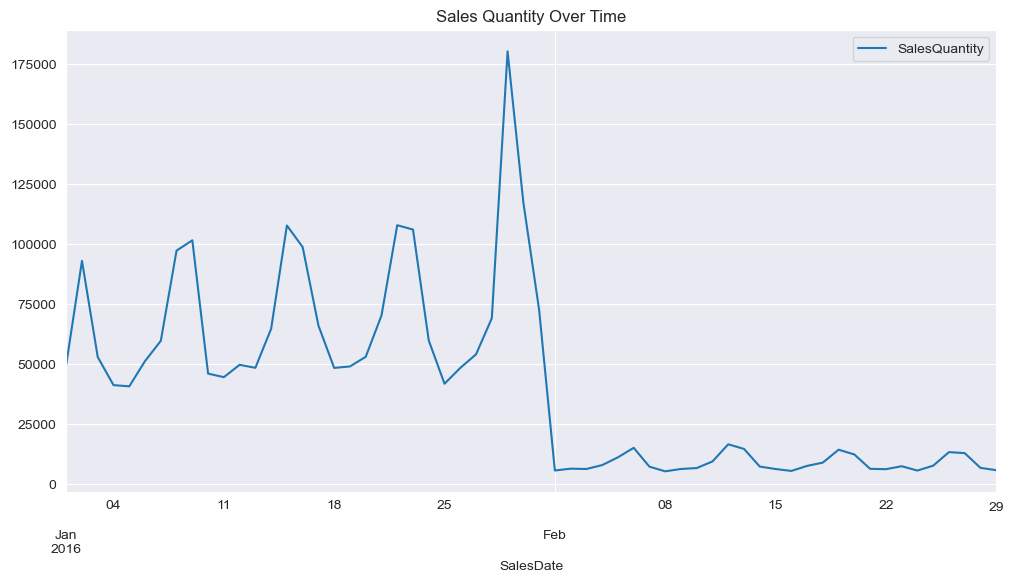

In [5]:
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])
sales_quantity_trend = sales.groupby('SalesDate').agg({'SalesQuantity': 'sum'})
sales_quantity_trend.plot(figsize=(12, 6), title='Sales Quantity Over Time')

Extract top 20 products demanded. Can also do ABC Analysis.

In [6]:
demand = sales.groupby(['SalesDate', 'Description']).agg({'SalesPrice': 'mean', 'SalesQuantity': 'sum'}).reset_index()

# Group by 'Brand' and sum the 'SalesQuantity'
top_products = demand.groupby('Description')['SalesQuantity'].sum().reset_index()

# Sort the result by 'SalesQuantity' in descending order and select the top 30
top_products = top_products.sort_values(by='SalesQuantity', ascending=False).head(20)

# Get the top 30 brand IDs
top_products_ids = top_products['Description'].tolist()

products = top_products_ids
print(len(products), products)

# Filter the demand data for only the top 30 brands
top_demand_data = demand[demand['Description'].isin(products)]

# Display the filtered data
print(top_demand_data)

top_demand_data.to_csv('demand.csv', index= False)


20 ['Smirnoff 80 Proof', 'Capt Morgan Spiced Rum', "Dr McGillicuddy's Mentholmnt", 'Yukon Jack', 'Jack Daniels No 7 Black', 'Absolut 80 Proof', 'Smirnoff Raspberry Vodka', 'Jim Beam', "Tito's Handmade Vodka", 'Canadian Club', 'Skyy Vodka', 'Bacardi Superior Rum', 'Baileys Irish Cream', 'Jameson Irish Whiskey', 'Kahlua', 'Pinnacle Vodka', 'Ketel One Vodka', 'Jose Cuervo Especial', 'Grey Goose Vodka', 'Jagermeister Liqueur']

        SalesDate               Description  SalesPrice  SalesQuantity

40     2016-01-01          Absolut 80 Proof   17.259231            503

203    2016-01-01      Bacardi Superior Rum   10.158208            427

217    2016-01-01       Baileys Irish Cream   17.838404            547

564    2016-01-01             Canadian Club    8.783814            316

599    2016-01-01    Capt Morgan Spiced Rum   14.594167            732

...           ...                       ...         ...            ...

152285 2016-02-29                Skyy Vodka   10.147895             

<Axes: title={'center': 'Demand Sum Over Time'}, xlabel='SalesDate'>

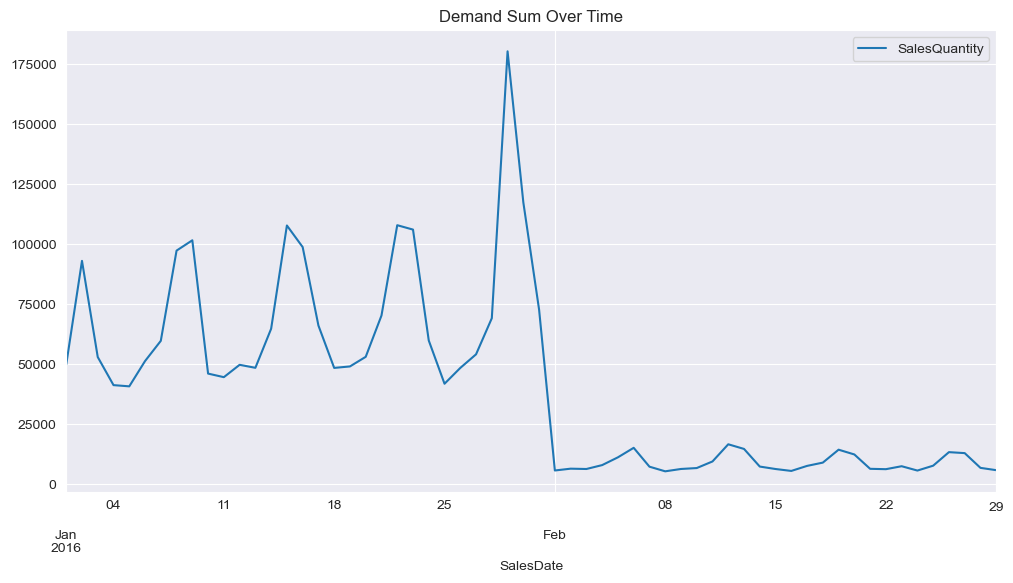

In [7]:
demand_trend = demand.groupby('SalesDate').agg({'SalesQuantity': 'sum'})
demand_trend.plot(figsize=(12, 6), title='Demand Sum Over Time')

**2. Supply Data**

In [ ]:
# Converting PODate and ReceivingDate columns to datetime
purchases['PODate'] = pd.to_datetime(purchases['PODate'], errors='coerce')
purchases['ReceivingDate'] = pd.to_datetime(purchases['ReceivingDate'], errors='coerce')

purchases['Lead_Time'] = (purchases['ReceivingDate'] - purchases['PODate']).dt.days

all_supply = purchases.groupby(['InvoiceDate', 'Description']).agg({'PurchasePrice': 'mean', 'Lead_Time': 'mean'}).reset_index()

# Filter all_supply to include only dates earlier than '2016-02-29'
filter_supply = all_supply[all_supply['InvoiceDate'] < '2016-02-29']

# Filter the supply data to include only specified products
top_supply = filter_supply[filter_supply['Description'].isin(products)]

# Generate the complete date range from 2016-01-01 to 2016-02-29 with daily frequency
date_range = pd.date_range(start='2016-01-01', end='2016-02-29', freq='D')

# Create a DataFrame with all combinations of dates and products
all_dates_products = pd.MultiIndex.from_product([date_range, products], names=['InvoiceDate', 'Description']).to_frame(index=False)

all_dates_products['InvoiceDate'] = all_dates_products['InvoiceDate'].astype('object')

# Merge the top_supply data with the all_dates_products to get all combinations
merged_data = pd.merge(all_dates_products, top_supply, on=['InvoiceDate', 'Description'], how='outer')

# Sort the data by Description and InvoiceDate
merged_data = merged_data.sort_values(by=['Description', 'InvoiceDate'])

# Forward fill the missing values
merged_data[['PurchasePrice', 'Lead_Time']] = merged_data[['PurchasePrice', 'Lead_Time']].ffill()

# Backward fill the remaining missing values (if any)
merged_data[['PurchasePrice', 'Lead_Time']] = merged_data[['PurchasePrice', 'Lead_Time']].bfill()


# Reset index to get a clean DataFrame
final_supply = merged_data.drop_duplicates(subset = ['InvoiceDate', 'Description']).reset_index(drop=True)



final_supply['LeadTime'] = np.round(final_supply['Lead_Time'])
final_supply.drop(columns=['Lead_Time'], inplace=True)

# Display the final DataFrame
print(final_supply)

final_supply.to_csv('supply.csv')

In [ ]:
beg_inventory = beg_inv.groupby(['Description','startDate']).agg({'onHand': 'sum'}).reset_index()
initial_inventory = beg_inventory[beg_inventory['Description'].isin(products)].reset_index()
print(initial_inventory)

initial_inventory.to_csv('initial_inventory.csv')

**3. Inventory Optimization**

A simplified model:

**Input:** 

sales price of each product each day (demand data)
purchase price of each product each day (supply data)
holding cost of each product each day (assume 0.1 * purchase price) 

fixed ordering freight cost (assume 0.1 * purchase price)
lead time (supply data)

beginning inventory 

**Output:**
Order amount of each product each day


**3.1 Reinforcement learning model**

# Reinforcement Learning Models for Inventory Optimization

## Overview

The objective is to minimize costs and maximize profits by making optimal ordering decisions based on the current state of demand, supply, and inventory levels. By leveraging RL, we aim to create a dynamic and adaptive system that responds to real-time data, potentially improving efficiency and profitability.

## Introduction

Traditional methods often rely on static models and assumptions, which may not adapt well to the dynamic nature of supply and demand. Reinforcement learning offers a promising alternative. By continuously learning from data, RL models can adapt to changes in demand and supply, potentially leading to more efficient inventory management.

## Models Used

We use the following RL algorithms from the `stable-baselines3` library:

| Algorithm | Optimizer      | In/Off Policy | Pros                                                                                       | Cons                                                                      |
|-----------|----------------|---------------|--------------------------------------------------------------------------------------------|---------------------------------------------------------------------------|
| **PPO**   | Adam           |On-Policy     | Stable training, good sample efficiency, easy to tune                                      | May require extensive hyperparameter tuning                               |
| **A2C**   | RMSprop        | On-Policy     | Simple to implement, good performance in various tasks                                     | High variance in gradient estimates                                       |
| **SAC**   | Adam           | Off-Policy    | Efficient exploration due to entropy term, good for continuous action spaces               | Computationally expensive                   |
| **DDPG**  | Adam |  Off-Policy    | Good for continuous action spaces, can handle high-dimensional action spaces               | Sensitive to hyperparameters, prone to overfitting and instability       |

### Parameters and Values (untuned default - may not be updated)

| Parameter                  | Description                                                                                         | PPO       | A2C       | SAC       | DDPG      |
|----------------------------|-----------------------------------------------------------------------------------------------------|-----------|-----------|-----------|-----------|
| **Learning Rate**          | The initial step size for the optimizer  | $3 \times 10^{-4}$  | $7 \times 10^{-4}$  | $3 \times 10^{-4}$  | $1 \times 10^{-3}$  |
| **Steps per Update**       | The number of steps to run for each environment per update (batch size).                            | 2048      | 5         | N/A       | N/A       |
| **Batch Size**             | The number of training examples used in one iteration.                                               | 64        | N/A       | 256       | 100       |
| **Epochs**                 | The number of times the learning algorithm will work through the entire training dataset.            | 10        | N/A       | N/A       | N/A       |
| **Discount Factor**        | The discount factor used to balance immediate and future rewards.                                     | 0.99      | 0.99      | 0.99      | 0.99      |
| **Entropy Coefficient**    | Coefficient for the entropy term added to the policy loss to encourage exploration.                   | N/A       | 0.01      | N/A       | N/A       |
| **GAE Lambda**             | The factor for the trade-off of bias vs. variance for Generalized Advantage Estimation.               | N/A       | 1.0       | N/A       | N/A       |
| **Tau**                    | The target smoothing coefficient for soft updates.                                                   | N/A       | N/A       | 0.005     | 0.005     |


## Environment Setup

The environment is implemented using the `gym` library. Here is a summary of the environment setup:

- **State**: The state includes the current inventory levels and the demand for the current day.
- **Action**: The action represents the order quantities for each product.
- **Reward**: The reward is calculated based on the profit, which considers revenue from sales, purchase costs, holding costs, and fixed ordering costs.
- **Observation Space**: A continuous space representing the inventory levels, demands, sales price, purchase price, lead time
- **Action Space**: A continuous space representing the order quantities.

## Training

**Profit is plotted to check policy performance after every 6000 timesteps (each model 18000 timesteps)**



In [1]:
def format_csv_files(demand_file, supply_file, initial_inventory_file):
    demand = pd.read_csv(demand_file)
    supply = pd.read_csv(supply_file)
    initial_inventory = pd.read_csv(initial_inventory_file)

    demand_formatted = demand.pivot(index='SalesDate', columns='Description', values='SalesQuantity')
    demand_formatted.index = pd.to_datetime(demand_formatted.index)
    demand_formatted = demand_formatted.sort_index()

    sales_price_formatted = demand.pivot(index='SalesDate', columns='Description', values='SalesPrice')
    sales_price_formatted.index = pd.to_datetime(sales_price_formatted.index)
    sales_price_formatted = sales_price_formatted.sort_index()

    supply_formatted = supply.pivot(index='InvoiceDate', columns='Description', values='PurchasePrice')
    supply_formatted.index = pd.to_datetime(supply_formatted.index)
    supply_formatted = supply_formatted.sort_index()

    lead_time_formatted = supply.pivot(index='InvoiceDate', columns='Description', values='LeadTime')
    lead_time_formatted.index = pd.to_datetime(lead_time_formatted.index)
    lead_time_formatted = lead_time_formatted.sort_index()

    initial_inventory_formatted = initial_inventory.set_index('Description').T
    initial_inventory_formatted = initial_inventory_formatted.iloc[[0]]

    return demand_formatted, sales_price_formatted, supply_formatted, lead_time_formatted, initial_inventory_formatted

In [21]:
from stable_baselines3 import PPO, A2C, SAC, DDPG
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
from collections import deque

class InventoryEnv(gym.Env):
    def __init__(self, demand, sales_price, supply, lead_time, initial_inventory, render_mode=None):
        super(InventoryEnv, self).__init__()

        self.demand = demand.values
        self.sales_price = sales_price.values
        self.supply = supply.values
        self.lead_time = lead_time.values
        self.initial_inventory = initial_inventory.values[0]

        self.num_products = self.demand.shape[1]
        self.num_days = self.demand.shape[0]

        self.action_space = gym.spaces.Box(low=0, high=1, shape=(self.num_products,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(self.num_products * 5,), dtype=np.float32)

        self.order_queue = [deque() for _ in range(self.num_products)]

        self.render_mode = render_mode
        self.reset()

    def reset(self):
        self.current_day = 0
        self.inventory = np.copy(self.initial_inventory)
        self.total_profit = 0
        self.order_queue = [deque() for _ in range(self.num_products)]
        self.inventory_history = [self.inventory.copy()]
        self.profit_history = [self.total_profit]
        return self._get_obs()

    def _get_obs(self):
        return np.concatenate([
            self.inventory,
            self.demand[self.current_day],
            self.sales_price[self.current_day],
            self.supply[self.current_day],
            self.lead_time[self.current_day]
        ])

    def step(self, action):
        action = action * self.demand[self.current_day]
        action = np.round(action)

        for p in range(self.num_products):
            lead_time = int(self.lead_time[self.current_day, p])
            self.order_queue[p].append((lead_time, action[p]))

        revenue = np.sum(action * self.sales_price[self.current_day])
        purchase_cost = np.sum(action * self.supply[self.current_day])
        holding_cost = np.sum(self.inventory * 0.1 * self.supply[self.current_day])
        fixed_cost = np.sum(0.1 * self.supply[self.current_day]) if np.any(action > 0) else 0

        profit = revenue - purchase_cost - holding_cost - fixed_cost
        self.total_profit += profit

        self.inventory = np.maximum(self.inventory - self.demand[self.current_day], 0)

        for p in range(self.num_products):
            if self.order_queue[p] and self.order_queue[p][0][0] == 0:
                _, quantity = self.order_queue[p].popleft()
                self.inventory[p] += quantity
            self.order_queue[p] = deque([(lt - 1, qty) for lt, qty in self.order_queue[p]])

        self.inventory_history.append(self.inventory.copy())
        self.profit_history.append(self.total_profit)

        self.current_day += 1
        done = self.current_day >= self.num_days
        obs = self._get_obs() if not done else np.concatenate([self.inventory,  # Actual inventory levels
                                                               np.zeros_like(self.demand[0]),  # Zero demand
                                                               np.zeros_like(self.sales_price[0]),  # Zero sales price 
                                                               np.zeros_like(self.supply[0]),  # Zero supply
                                                               np.zeros_like(self.lead_time[0])])  # Zero lead time
                                                              
        return obs, profit, done, {}

    def render(self, mode='human'):
        if self.render_mode == 'human':

            fig, ax1 = plt.subplots()

            ax1.set_xlabel('Day')
            ax1.set_ylabel('Inventory Level', color='tab:blue')
            for i in range(self.num_products):
                ax1.plot(range(len(self.inventory_history)), [inv[i] for inv in self.inventory_history], label=f'Product {i+1}')
            ax1.tick_params(axis='y', labelcolor='tab:blue')

            ax2 = ax1.twinx()
            ax2.set_ylabel('Total Profit', color='tab:red')
            ax2.plot(range(len(self.profit_history)), self.profit_history, color='tab:red', label='Total Profit')
            ax2.tick_params(axis='y', labelcolor='tab:red')

            fig.tight_layout()
            plt.title('Inventory Levels and Total Profit Over Time')
            ax1.legend(loc='upper left')
            ax2.legend(loc='upper right')
            plt.show()


def train_and_evaluate_rl(demand_file, supply_file, initial_inventory_file, render_mode=None, num_epochs = 3):
    demand, sales_price, supply, lead_time, initial_inventory = format_csv_files(demand_file, supply_file, initial_inventory_file)

    env = DummyVecEnv([lambda: InventoryEnv(demand, sales_price, supply, lead_time, initial_inventory, render_mode=render_mode)])

    models = {
        'PPO': PPO('MlpPolicy', env, verbose=0),
        'A2C': A2C('MlpPolicy', env, verbose=0),
        'SAC': SAC('MlpPolicy', env, verbose=0),
        'DDPG': DDPG('MlpPolicy', env, verbose=0)
    }

    profits = {}
    for model_name, model in models.items():
        print(f'Training {model_name}...')
        
        for epoch in range(num_epochs):
            print("epoch", epoch+1, "out of", num_epochs)
            
            model.learn(total_timesteps=6000)
    
            obs = env.reset()
            profits[model_name] = []
            total_profit = 0
            
            for _ in range(demand.shape[0]):
                action, _states = model.predict(obs)
                obs, reward, done, info = env.step(action)
                total_profit += reward[0]
                profits[model_name].append(total_profit)
                
                if _ + 2 == demand.shape[0]:  # Render 
                    env.get_attr('render')[0]()
                
                if done[0]:
                    obs = env.reset()
                    break
    return profits


C:\Users\shawn\miniconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.

  warnings.warn(


Training PPO...

epoch 1 out of 3


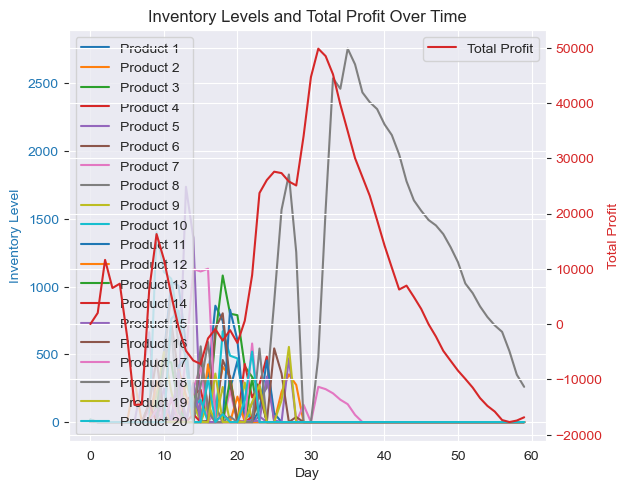

epoch 2 out of 3


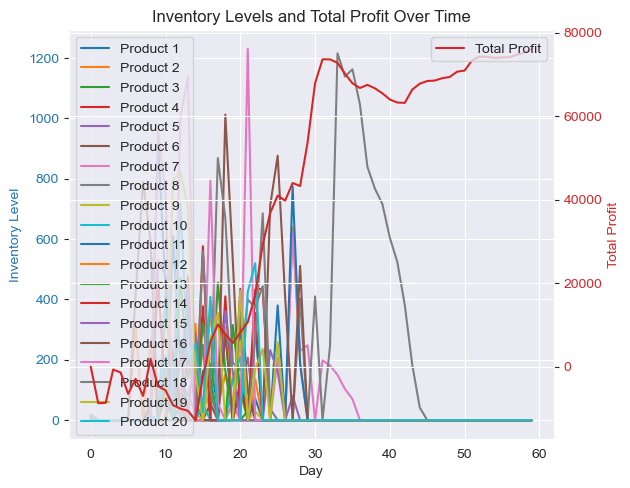

epoch 3 out of 3


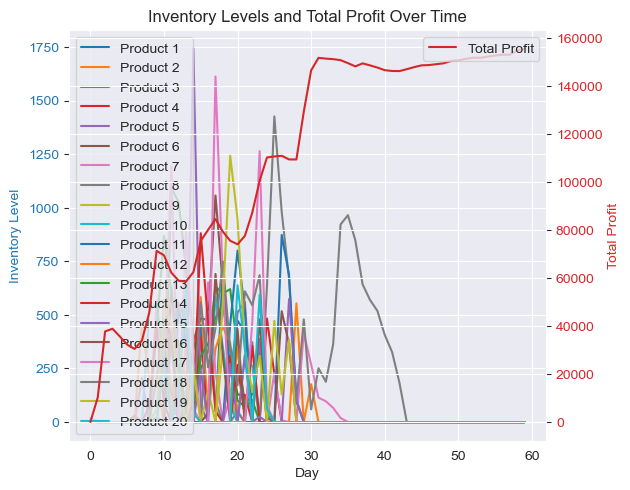

Training A2C...

epoch 1 out of 3


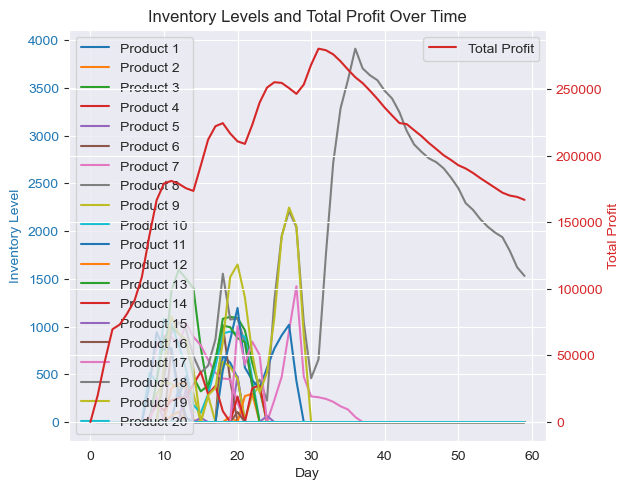

epoch 2 out of 3


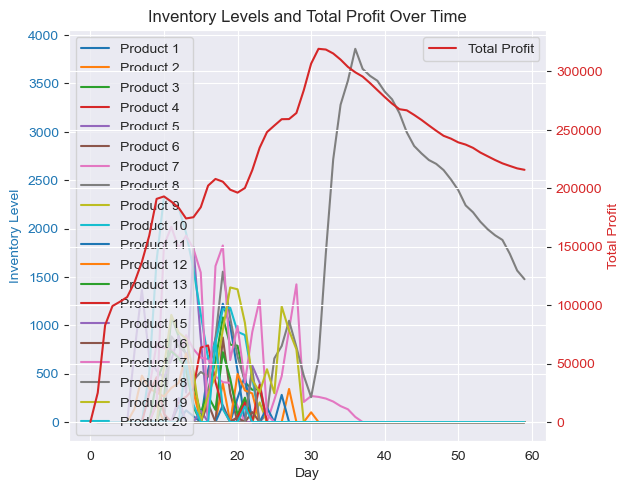

epoch 3 out of 3


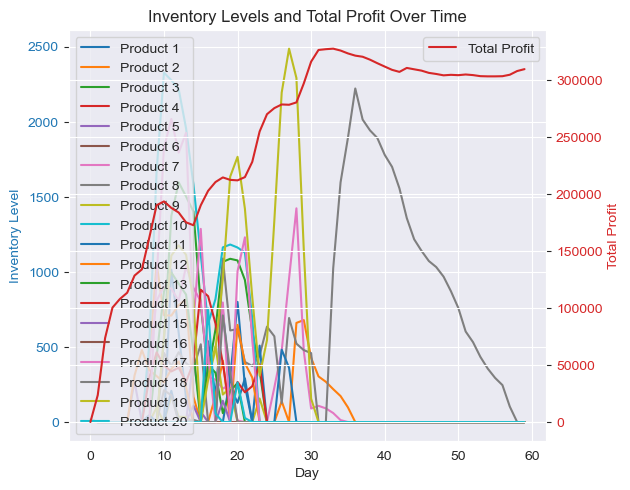

Training SAC...

epoch 1 out of 3


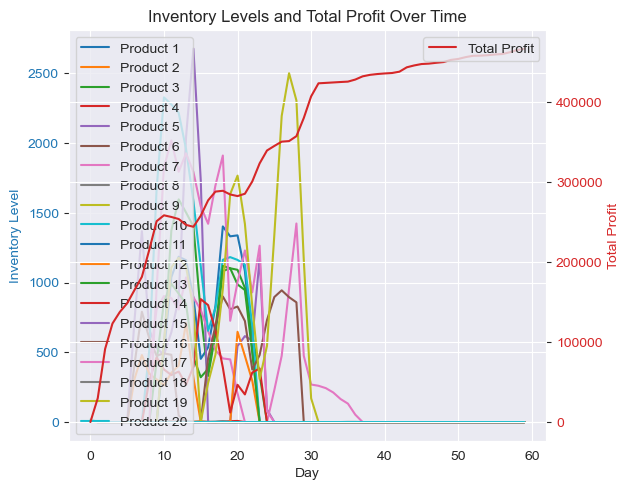

epoch 2 out of 3


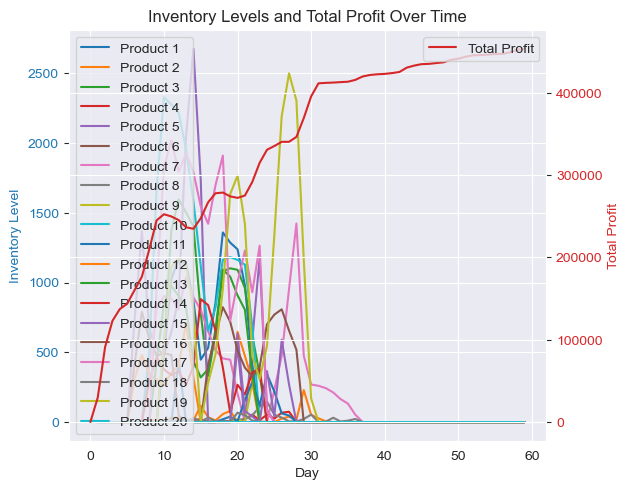

epoch 3 out of 3


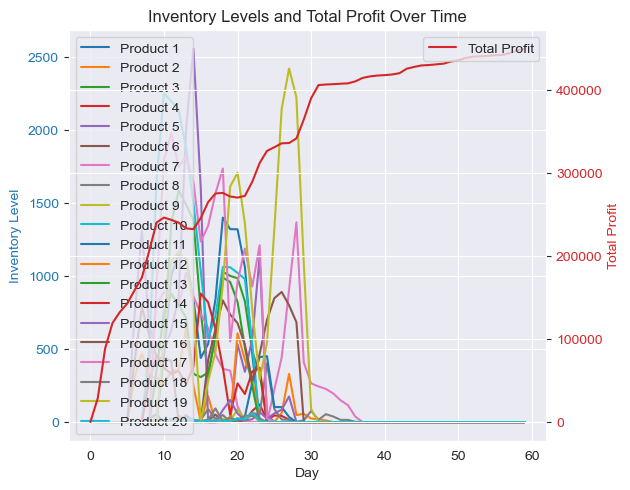

Training DDPG...

epoch 1 out of 3


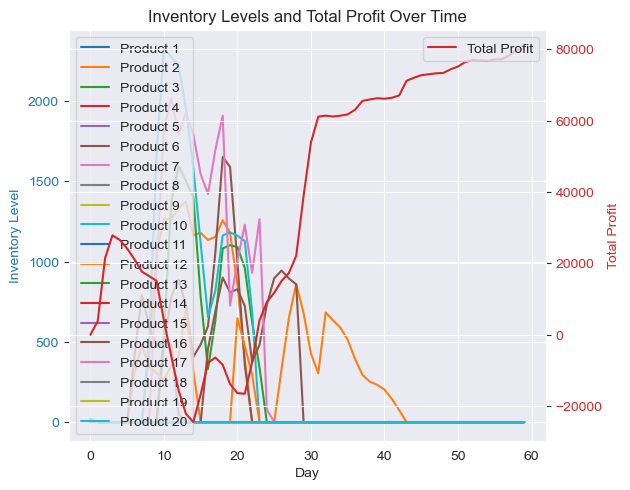

epoch 2 out of 3


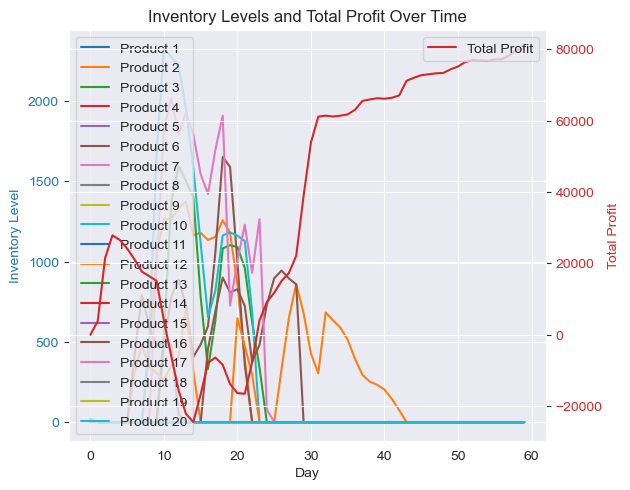

epoch 3 out of 3


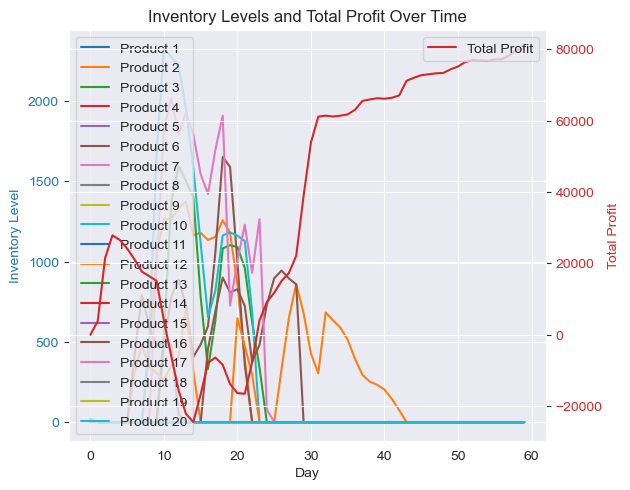

In [22]:
%matplotlib inline

demand_file = 'demand.csv'
supply_file = 'supply.csv'
initial_inventory_file = 'initial_inventory.csv'

# Calculate cumulative profit using RL models
rl_profits = train_and_evaluate_rl(demand_file, supply_file, initial_inventory_file, render_mode='human')

**3.2 Optimization: Mixed integer linear programming model**

Two models: opt and opt_freq

opt model minimizes the cost during the whole period of 60 days.

opt_freq minimizes 3-day and 30-day model.

#### Optimization Model Formulation

##### Sets and Parameters
- $T$: Set of time periods (days).
- $P$: Set of products.
- $D_{tp}$: Demand for product $p$ on day $t$.
- $S_{tp}$: Sales price for product $p$ on day $t$.
- $C_{tp}$: Purchase cost for product $p$ on day $t$.
- $H_{tp}$: Holding cost for product $p$ on day $t$ (set to $0.1 \times C_{tp}$).
- $F_p$: Fixed ordering cost for product $p$ (set to $0.1 \times C_{1p}$).
- $L_{tp}$: Lead time for product $p$ on day $t$.
- $I_{0p}$: Initial inventory level for product $p$.

##### Decision Variables
- $Q_{tp}$: Order quantity for product $p$ on day $t$.
- $I_{tp}$: Inventory level for product $p$ on day $t$.
- $O_{tp}$: Binary variable indicating if an order is placed for product $p$ on day $t$.

##### Objective Function
Minimize the total cost, which includes holding cost, purchase cost, and fixed ordering cost:
$$
\text{Minimize } \sum_{t \in T} \sum_{p \in P} \left( H_{tp} I_{tp} + C_{tp} Q_{tp} + F_p O_{tp} \right)
$$

#### Constraints
##### Inventory Balance Constraint
$$
I_{tp} = 
\begin{cases} 
I_{0p} + Q_{tp} - D_{tp} & \text{ if } t = 1 \\
I_{t-1, p} + Q_{t-L_{tp}, p} - D_{tp} & \text{ if } t > 1 \text{ and } t - L_{tp} > 0 \\
I_{t-1, p} - D_{tp} & \text{ otherwise}
\end{cases}
$$

#### Order Logic Constraint
$$
Q_{tp} \leq O_{tp} \times M
$$
where \( M \) is a large number (e.g., \( 10^6 \)).



#### * Optimization_Freq Model
For the 3-day optimization, the objective and constraints remain the same, but the set of days \( T \) is limited to a sliding window of 3 days. 

##### Sets and Parameters for 3-day Window
$$
T_{window} = \{ \text{start\_day}, \ldots, \min(\text{start\_day} + 2, \text{total\_days}) \}
$$

##### Objective Function 
$$
\text{Minimize } \sum_{t \in T_{window}} \sum_{p \in P} \left( H_{tp} I_{tp} + C_{tp} Q_{tp} + F_p O_{tp} \right)
$$

##### Constraints 
The constraints are the same as the original model, applied only within the time window.

**opt.py**

In [27]:
def format_csv_files(demand_file, supply_file, initial_inventory_file):
    demand = pd.read_csv(demand_file)
    supply = pd.read_csv(supply_file)
    initial_inventory = pd.read_csv(initial_inventory_file)

    demand_formatted = demand.pivot(index='SalesDate', columns='Description', values='SalesQuantity')
    demand_formatted.index = pd.to_datetime(demand_formatted.index)
    demand_formatted = demand_formatted.sort_index()

    sales_price_formatted = demand.pivot(index='SalesDate', columns='Description', values='SalesPrice')
    sales_price_formatted.index = pd.to_datetime(sales_price_formatted.index)
    sales_price_formatted = sales_price_formatted.sort_index()

    supply_formatted = supply.pivot(index='InvoiceDate', columns='Description', values='PurchasePrice')
    supply_formatted.index = pd.to_datetime(supply_formatted.index)
    supply_formatted = supply_formatted.sort_index()

    lead_time_formatted = supply.pivot(index='InvoiceDate', columns='Description', values='LeadTime')
    lead_time_formatted.index = pd.to_datetime(lead_time_formatted.index)
    lead_time_formatted = lead_time_formatted.sort_index()

    initial_inventory_formatted = initial_inventory.set_index('Description').T
    initial_inventory_formatted = initial_inventory_formatted.iloc[[0]]

    return demand_formatted, sales_price_formatted, supply_formatted, lead_time_formatted, initial_inventory_formatted


def optimize_inventory(demand_file, supply_file, initial_inventory_file):
    demand, sales_price, supply, lead_time, initial_inventory = format_csv_files(demand_file, supply_file,
                                                                                 initial_inventory_file)

    model = ConcreteModel()
    model.T = RangeSet(1, len(demand))
    model.P = RangeSet(1, len(demand.columns))

    model.demand = Param(model.T, model.P, initialize=lambda model, t, p: demand.iloc[t - 1, p - 1])
    model.sales_price = Param(model.T, model.P, initialize=lambda model, t, p: sales_price.iloc[t - 1, p - 1])
    model.purchase_price = Param(model.T, model.P, initialize=lambda model, t, p: supply.iloc[t - 1, p - 1])
    model.holding_cost = Param(model.T, model.P, initialize=lambda model, t, p: 0.1 * supply.iloc[t - 1, p - 1])
    model.fixed_cost = Param(model.P, initialize=lambda model, p: 0.1 * supply.iloc[0, p - 1])
    model.lead_time = Param(model.T, model.P, initialize=lambda model, t, p: lead_time.iloc[t - 1, p - 1])
    model.initial_inventory = Param(model.P, initialize=lambda model, p: initial_inventory.iloc[0, p - 1])

    model.order_quantity = Var(model.T, model.P, domain=NonNegativeReals)
    model.inventory_level = Var(model.T, model.P, domain=NonNegativeReals)
    model.order_placed = Var(model.T, model.P, domain=Binary)

    def total_cost(model):
        holding_cost = sum(model.holding_cost[t, p] * model.inventory_level[t, p] for t in model.T for p in model.P)
        purchase_cost = sum(model.purchase_price[t, p] * model.order_quantity[t, p] for t in model.T for p in model.P)
        fixed_cost = sum(model.fixed_cost[p] * model.order_placed[t, p] for t in model.T for p in model.P)
        return holding_cost + purchase_cost + fixed_cost

    model.total_cost = Objective(rule=total_cost, sense=minimize)

    def inventory_balance(model, t, p):
        if t == 1:
            return model.inventory_level[t, p] == model.initial_inventory[p] + model.order_quantity[t, p] - \
                model.demand[t, p]
        else:
            lead_time = model.lead_time[t, p]
            if t - lead_time > 0:
                return model.inventory_level[t, p] == model.inventory_level[t - 1, p] + model.order_quantity[
                    t - lead_time, p] - model.demand[t, p]
            else:
                return model.inventory_level[t, p] == model.inventory_level[t - 1, p] - model.demand[t, p]

    model.inventory_balance = Constraint(model.T, model.P, rule=inventory_balance)

    def order_logic(model, t, p):
        return model.order_quantity[t, p] <= model.order_placed[t, p] * 1e6

    model.order_logic = Constraint(model.T, model.P, rule=order_logic)

    opt = SolverFactory('gurobi')
    result = opt.solve(model, tee=True)

    order_quantity = pd.DataFrame(index=range(1, len(demand) + 1), columns=demand.columns)
    inventory_level = pd.DataFrame(index=range(1, len(demand) + 1), columns=demand.columns)

    for t in model.T:
        for p in model.P:
            order_quantity.iloc[t - 1, p - 1] = model.order_quantity[t, p].value
            inventory_level.iloc[t - 1, p - 1] = model.inventory_level[t, p].value

    return order_quantity, inventory_level


def calculate_cumulative_profit(demand_file, supply_file, initial_inventory_file):
    order_quantity, inventory_level = optimize_inventory(demand_file, supply_file, initial_inventory_file)
    demand, sales_price, supply, lead_time, initial_inventory = format_csv_files(demand_file, supply_file,
                                                                                 initial_inventory_file)

    daily_profit = pd.DataFrame(index=order_quantity.index, columns=order_quantity.columns)
    for t in order_quantity.index:
        for p in order_quantity.columns:
            revenue = demand.iloc[t - 1][p] * sales_price.iloc[t - 1][p]
            purchase_cost = order_quantity.loc[t, p] * supply.iloc[t - 1][p]
            holding_cost = inventory_level.loc[t, p] * 0.1 * supply.iloc[t - 1][p]
            fixed_cost = 0.1 * supply.iloc[t - 1][p] if order_quantity.loc[t, p] > 0 else 0
            daily_profit.loc[t, p] = revenue - purchase_cost - holding_cost - fixed_cost

    daily_profit['Total'] = daily_profit.sum(axis=1)
    cumulative_profit = daily_profit['Total'].cumsum()

    return cumulative_profit


**opt_frequence.py**

In [46]:

def format_csv_files(demand_file, supply_file, initial_inventory_file):
    demand = pd.read_csv(demand_file)
    supply = pd.read_csv(supply_file)
    initial_inventory = pd.read_csv(initial_inventory_file)

    demand_formatted = demand.pivot(index='SalesDate', columns='Description', values='SalesQuantity')
    demand_formatted.index = pd.to_datetime(demand_formatted.index)
    demand_formatted = demand_formatted.sort_index()

    sales_price_formatted = demand.pivot(index='SalesDate', columns='Description', values='SalesPrice')
    sales_price_formatted.index = pd.to_datetime(sales_price_formatted.index)
    sales_price_formatted = sales_price_formatted.sort_index()

    supply_formatted = supply.pivot(index='InvoiceDate', columns='Description', values='PurchasePrice')
    supply_formatted.index = pd.to_datetime(supply_formatted.index)
    supply_formatted = supply_formatted.sort_index()

    lead_time_formatted = supply.pivot(index='InvoiceDate', columns='Description', values='LeadTime')
    lead_time_formatted.index = pd.to_datetime(lead_time_formatted.index)
    lead_time_formatted = lead_time_formatted.sort_index()

    initial_inventory_formatted = initial_inventory.set_index('Description').T
    initial_inventory_formatted = initial_inventory_formatted.iloc[[0]]

    return demand_formatted, sales_price_formatted, supply_formatted, lead_time_formatted, initial_inventory_formatted

def optimize_inventory_freq(demand, sales_price, supply, lead_time, initial_inventory, start_day, time_window):
    model = ConcreteModel()
    model.T = RangeSet(start_day, start_day + time_window - 1)
    model.P = RangeSet(1, len(demand.columns))

    model.demand = Param(model.T, model.P, initialize=lambda model, t, p: demand.iloc[t - 1, p - 1])
    model.sales_price = Param(model.T, model.P, initialize=lambda model, t, p: sales_price.iloc[t - 1, p - 1])
    model.purchase_price = Param(model.T, model.P, initialize=lambda model, t, p: supply.iloc[t - 1, p - 1])
    model.holding_cost = Param(model.T, model.P, initialize=lambda model, t, p: 0.1 * supply.iloc[t - 1, p - 1])
    model.fixed_cost = Param(model.P, initialize=lambda model, p: 0.1 * supply.iloc[start_day - 1, p - 1])
    model.lead_time = Param(model.T, model.P, initialize=lambda model, t, p: lead_time.iloc[t - 1, p - 1])
    model.initial_inventory = Param(model.P, initialize=lambda model, p: initial_inventory.iloc[0, p - 1])

    model.order_quantity = Var(model.T, model.P, domain=NonNegativeReals)
    model.inventory_level = Var(model.T, model.P, domain=NonNegativeReals)
    model.order_placed = Var(model.T, model.P, domain=Binary)

    def total_cost(model):
        holding_cost = sum(model.holding_cost[t, p] * model.inventory_level[t, p] for t in model.T for p in model.P)
        purchase_cost = sum(model.purchase_price[t, p] * model.order_quantity[t, p] for t in model.T for p in model.P)
        fixed_cost = sum(model.fixed_cost[p] * model.order_placed[t, p] for t in model.T for p in model.P)
        return holding_cost + purchase_cost + fixed_cost

    model.total_cost = Objective(rule=total_cost, sense=minimize)

    def inventory_balance(model, t, p):
        if t == start_day:
            return model.inventory_level[t, p] == model.initial_inventory[p] + model.order_quantity[t, p] - \
                model.demand[t, p]
        else:
            lead_time = model.lead_time[t, p]
            if t - lead_time >= start_day:
                return model.inventory_level[t, p] == model.inventory_level[t - 1, p] + model.order_quantity[
                    t - lead_time, p] - model.demand[t, p]
            else:
                return model.inventory_level[t, p] == model.inventory_level[t - 1, p] - model.demand[t, p]

    model.inventory_balance = Constraint(model.T, model.P, rule=inventory_balance)

    def order_logic(model, t, p):
        return model.order_quantity[t, p] <= model.order_placed[t, p] * 1e6

    model.order_logic = Constraint(model.T, model.P, rule=order_logic)

    opt = SolverFactory('gurobi')
    result = opt.solve(model, tee=True)

    order_quantity = pd.DataFrame(index=range(start_day, start_day + time_window), columns=demand.columns)
    inventory_level = pd.DataFrame(index=range(start_day, start_day + time_window), columns=demand.columns)

    for t in model.T:
        for p in model.P:
            order_quantity.iloc[t - start_day, p - 1] = model.order_quantity[t, p].value
            inventory_level.iloc[t - start_day, p - 1] = model.inventory_level[t, p].value

    return order_quantity, inventory_level


def calculate_cumulative_profit_freq(demand_file, supply_file, initial_inventory_file, time_window):
    demand, sales_price, supply, lead_time, initial_inventory = format_csv_files(demand_file, supply_file,
                                                                                 initial_inventory_file)
    total_periods = len(demand)
    order_quantity_all = pd.DataFrame(index=range(1, total_periods + 1), columns=demand.columns)
    inventory_level_all = pd.DataFrame(index=range(1, total_periods + 1), columns=demand.columns)

    for start_day in range(1, total_periods + 1, time_window):
        end_day = min(start_day + time_window - 1, total_periods)
        order_quantity, inventory_level = optimize_inventory_freq(demand, sales_price, supply, lead_time,
                                                                  initial_inventory, start_day, time_window)
        order_quantity_all.loc[start_day:end_day] = order_quantity
        inventory_level_all.loc[start_day:end_day] = inventory_level

    daily_profit = pd.DataFrame(index=order_quantity_all.index, columns=order_quantity_all.columns)
    for t in order_quantity_all.index:
        for p in order_quantity_all.columns:
            revenue = demand.iloc[t - 1][p] * sales_price.iloc[t - 1][p]
            purchase_cost = order_quantity_all.loc[t, p] * supply.iloc[t - 1][p]
            holding_cost = inventory_level_all.loc[t, p] * 0.1 * supply.iloc[t - 1][p]
            fixed_cost = 0.1 * supply.iloc[t - 1][p] if order_quantity_all.loc[t, p] > 0 else 0
            daily_profit.loc[t, p] = revenue - purchase_cost - holding_cost - fixed_cost

    daily_profit['Total'] = daily_profit.sum(axis=1)
    cumulative_profit = daily_profit['Total'].cumsum()

    return cumulative_profit

In [ ]:
demand_file = 'demand.csv'
supply_file = 'supply.csv'
initial_inventory_file = 'initial_inventory.csv'

# Calculate cumulative profit using optimization
opt_profits = calculate_cumulative_profit(demand_file, supply_file, initial_inventory_file)

# Calculate cumulative profit using opt_freq
opt_freq_profits_3day = calculate_cumulative_profit_freq(demand_file, supply_file, initial_inventory_file, 3)
opt_freq_profits_10day = calculate_cumulative_profit_freq(demand_file, supply_file, initial_inventory_file, 10)
opt_freq_profits_20day = calculate_cumulative_profit_freq(demand_file, supply_file, initial_inventory_file, 20)
opt_freq_profits_30day = calculate_cumulative_profit_freq(demand_file, supply_file, initial_inventory_file, 30)


**On-policy methods PPO and A2C indeed required more data to converge. Off-policy SAC and DDPG already converged in the first 1/3 updates.**

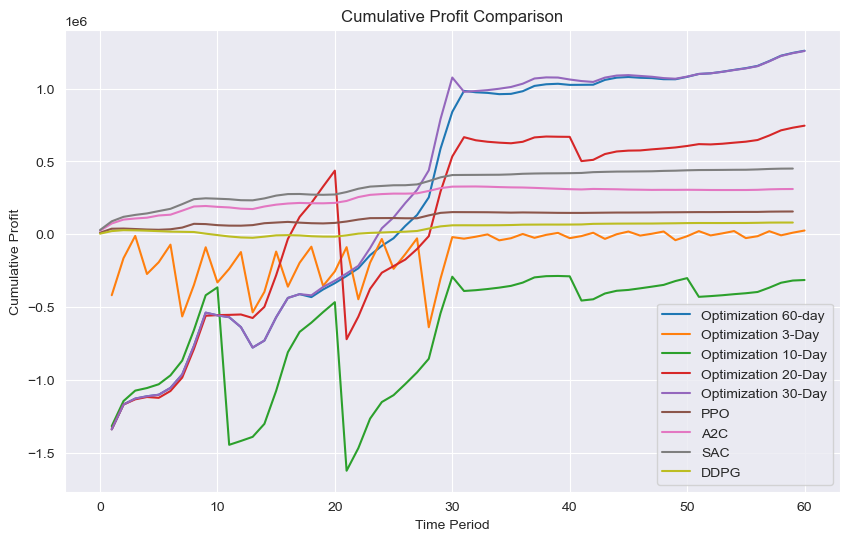

In [56]:
def plot_comparison(opt_profits, opt_freq_profits_3day, opt_freq_profits_10day, opt_freq_profits_20day, opt_freq_profits_30day, rl_profits):
    plt.figure(figsize=(10, 6))

    plt.plot(opt_profits, label='Optimization 60-day')
    plt.plot(opt_freq_profits_3day, label='Optimization 3-Day')
    plt.plot(opt_freq_profits_10day, label='Optimization 10-Day')
    plt.plot(opt_freq_profits_20day, label='Optimization 20-Day')
    plt.plot(opt_freq_profits_30day, label='Optimization 30-Day')
    for model_name, profit in rl_profits.items():
        plt.plot(profit, label=model_name)

    plt.title('Cumulative Profit Comparison')
    plt.xlabel('Time Period')
    plt.ylabel('Cumulative Profit')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot comparison
plot_comparison(opt_profits, opt_freq_profits_3day, opt_freq_profits_10day, opt_freq_profits_20day, opt_freq_profits_30day, rl_profits)

### Insights from Cumulative Profit Comparison

- **Optimization Performance**: 
    - 30 and 60 day model show dramatic increase in profitability after approximately 30 time periods
    - 3-day model show low performance, but 10 day model performs even more poorly
    - 20-day is a reasonable benchmark 
    - Sharp change in profit for the optimization method is a potential drawback
- **Reinforcement Learning Models**: 
    - All RL models provides steadily increasing profit through the period
    - All better than 3-day and 10-day optimization
    - DDPG exhibits the lowest performance, may worth investigating
    - SAC performs pretty well, close to 20-day optimization, probably due to usually better exploration
    - Will be better with some tuning

## To Do 

1. **RL Hyperparameter Tuning**: Further tune hyperparameters of the RL models to improve their profitability
2. **Extended Evaluation**: Perform extended evaluation on a larger dataset to validate the scalability and robustness of the models.
3. **RL Integration with Optimization techniques**: Explore the integration of the best-performing RL models with implementable optimization techniques / models.